1. We will collect the Stock Data-- AAPL
2. Preprocess the Data- Train and Test
3. Create An Stacked LSTM model
4. Predict the test data amd plot output
5. Predict the future 30 days and plot the output

# 1-) Collect the Stock Data-- AAPL

In [1]:
# Up to date remote data access for pandas, works for multiple versions of pandas.

# !pip install pandas-datareader

import pandas_datareader as pdr

Functions from pandas_datareader.data and pandas_datareader.wb extract data from various Internet sources into a pandas DataFrame. Currently the following sources are supported:

Tiingo is one of them. Tiingo is a tracing platform that provides a data api with historical end-of-day prices on equities, mutual funds and ETFs. Free registration is required to get an API key. Free accounts are rate limited and can access a limited number of symbols (500 at the time of writing).

In [2]:
key="5aa250503841f7df9664eb7e97245cdb57943117"

df = pdr.get_data_tiingo('AAPL', api_key=key)

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.head()

close    high      low    open     volume  \
symbol date                                                                    
AAPL   2015-08-06 00:00:00+00:00  115.13  116.50  114.115  115.97   52903040   
       2015-08-07 00:00:00+00:00  115.52  116.25  114.500  114.58   38670405   
       2015-08-10 00:00:00+00:00  119.72  119.99  116.530  116.53   54951597   
       2015-08-11 00:00:00+00:00  113.49  118.18  113.330  117.81   97082814   
       2015-08-12 00:00:00+00:00  115.24  115.42  109.630  112.53  101685610   

                                    adjClose     adjHigh      adjLow  \
symbol date                                                            
AAPL   2015-08-06 00:00:00+00:00  106.574181  107.842371  105.634610   
       2015-08-07 00:00:00+00:00  106.935199  107.610949  105.990999   
       2015-08-10 00:00:00+00:00  110.823078  111.073013  107.870141   
       2015-08-11 00:00:00+00:00  105.056057  109.397522  104.907947   
       2015-08-12 00:00:00+00:00  106.676007  106.842630  101.482911   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
AAPL   2015-08-06 00:00:00+00:00  107.351757   52903040     0.52          1.0  
       2015-08-07 00:00:00+00:00  106.065054   38670405     0.00          1.0  
       2015-08-10 00:00:00+00:00  107.870141   54951597     0.00          1.0  
       2015-08-11 00:00:00+00:00  109.055019   97082814     0.00          1.0  
       2015-08-12 00:00:00+00:00  104.167399  101685610     0.00          1.0

In [5]:
df.tail()

close      high     low     open    volume  \
symbol date                                                                     
AAPL   2020-07-28 00:00:00+00:00  373.01  378.1986  372.99  377.470  25906375   
       2020-07-29 00:00:00+00:00  380.16  380.9200  374.85  375.000  22582314   
       2020-07-30 00:00:00+00:00  384.76  385.1900  375.07  376.750  39532505   
       2020-07-31 00:00:00+00:00  425.04  425.6600  403.30  411.535  93573867   
       2020-08-03 00:00:00+00:00  435.75  446.5457  431.57  432.800  77037847   

                                  adjClose   adjHigh  adjLow  adjOpen  \
symbol date                                                             
AAPL   2020-07-28 00:00:00+00:00    373.01  378.1986  372.99  377.470   
       2020-07-29 00:00:00+00:00    380.16  380.9200  374.85  375.000   
       2020-07-30 00:00:00+00:00    384.76  385.1900  375.07  376.750   
       2020-07-31 00:00:00+00:00    425.04  425.6600  403.30  411.535   
       2020-08-03 00:00:00+00:00    435.75  446.5457  431.57  432.800   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2020-07-28 00:00:00+00:00   25906375      0.0          1.0  
       2020-07-29 00:00:00+00:00   22582314      0.0          1.0  
       2020-07-30 00:00:00+00:00   39532505      0.0          1.0  
       2020-07-31 00:00:00+00:00   93573867      0.0          1.0  
       2020-08-03 00:00:00+00:00   77037847      0.0          1.0

**Univariate time series**: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

**Multivariate time series**: Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

In [6]:
# We will focus univariate time series

df1 = df.reset_index()['close']

In [7]:
df1.shape

(1257,)

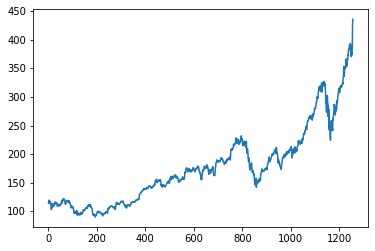

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
print(df1)

[[0.07176978]
 [0.07289887]
 [0.08505834]
 ...
 [0.85237833]
 [0.96899337]
 [1.        ]]


# 2-) Preprocess the Data 

- In time series machine learning analysis, our observations are not independent, and thus we cannot split the data randomly as we do in non-time-series analysis. Instead, we usually split observations along with the sequences.

In [11]:
# splitting dataset for timeseries is very important
# we split now manualy

training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
train_data.shape, test_data.shape

((817, 1), (440, 1))

In [13]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
print(X_train.shape), print(X_test.shape)

(716, 100, 1)
(339, 100, 1)


(None, None)

# 3-) Create LSTM Model

In [19]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 4s 333ms/step - loss: 0.0123 - val_loss: 0.0410
Epoch 2/100
12/12 [==============================] - 2s 199ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 3/100
12/12 [==============================] - 2s 196ms/step - loss: 5.5459e-04 - val_loss: 0.0031
Epoch 4/100
12/12 [==============================] - 3s 223ms/step - loss: 3.6295e-04 - val_loss: 0.0022
Epoch 5/100
12/12 [==============================] - 3s 245ms/step - loss: 3.4712e-04 - val_loss: 0.0021
Epoch 6/100
12/12 [==============================] - 3s 233ms/step - loss: 3.1271e-04 - val_loss: 0.0021
Epoch 7/100
12/12 [==============================] - 3s 237ms/step - loss: 3.0027e-04 - val_loss: 0.0025
Epoch 8/100
12/12 [==============================] - 3s 221ms/step - loss: 2.9648e-04 - val_loss: 0.0023
Epoch 9/100
12/12 [==============================] - 2s 194ms/step - loss: 2.9705e-04 - val_loss: 0.0023
Epoch 10/100
12/12 [==============================] - 2s 198ms/

Epoch 78/100
12/12 [==============================] - 2s 193ms/step - loss: 1.3769e-04 - val_loss: 8.3822e-04
Epoch 79/100
12/12 [==============================] - 2s 203ms/step - loss: 1.8371e-04 - val_loss: 0.0029
Epoch 80/100
12/12 [==============================] - 2s 195ms/step - loss: 1.9630e-04 - val_loss: 8.4480e-04
Epoch 81/100
12/12 [==============================] - 2s 191ms/step - loss: 1.9897e-04 - val_loss: 0.0026
Epoch 82/100
12/12 [==============================] - 2s 191ms/step - loss: 1.7502e-04 - val_loss: 8.2247e-04
Epoch 83/100
12/12 [==============================] - 2s 194ms/step - loss: 1.3709e-04 - val_loss: 0.0019
Epoch 84/100
12/12 [==============================] - 2s 195ms/step - loss: 1.5407e-04 - val_loss: 9.3384e-04
Epoch 85/100
12/12 [==============================] - 2s 193ms/step - loss: 1.3601e-04 - val_loss: 0.0015
Epoch 86/100
12/12 [==============================] - 2s 195ms/step - loss: 1.2009e-04 - val_loss: 7.6213e-04
Epoch 87/100
12/12 [======

In [23]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [24]:
train_predict

array([[0.04648069],
       [0.04702027],
       [0.04782088],
       [0.0481277 ],
       [0.04778293],
       [0.04635154],
       [0.04361935],
       [0.03913017],
       [0.03360842],
       [0.02833979],
       [0.02443388],
       [0.02170366],
       [0.02041578],
       [0.01991102],
       [0.01968156],
       [0.01952018],
       [0.01925354],
       [0.01993712],
       [0.02129396],
       [0.02305117],
       [0.02348888],
       [0.02236019],
       [0.02072947],
       [0.01906417],
       [0.0172484 ],
       [0.0157746 ],
       [0.01489903],
       [0.01408866],
       [0.01337221],
       [0.01278841],
       [0.01221315],
       [0.01151883],
       [0.01079591],
       [0.01068795],
       [0.01161239],
       [0.01302198],
       [0.01442459],
       [0.01570287],
       [0.01629705],
       [0.01640282],
       [0.01634975],
       [0.01633487],
       [0.0163703 ],
       [0.01723665],
       [0.01901482],
       [0.02152668],
       [0.0246495 ],
       [0.027

In [25]:
##Transformback to original form (Undo the scaling of X according to feature_range.)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
train_predict

array([[106.3949  ],
       [106.58127 ],
       [106.85781 ],
       [106.96379 ],
       [106.8447  ],
       [106.35028 ],
       [105.406555],
       [103.85595 ],
       [101.948685],
       [100.128845],
       [ 98.77971 ],
       [ 97.83666 ],
       [ 97.391815],
       [ 97.21747 ],
       [ 97.13821 ],
       [ 97.08246 ],
       [ 96.990364],
       [ 97.22649 ],
       [ 97.69515 ],
       [ 98.30211 ],
       [ 98.45329 ],
       [ 98.06343 ],
       [ 97.500175],
       [ 96.92495 ],
       [ 96.29777 ],
       [ 95.78871 ],
       [ 95.48627 ],
       [ 95.20637 ],
       [ 94.9589  ],
       [ 94.75725 ],
       [ 94.55854 ],
       [ 94.318726],
       [ 94.06902 ],
       [ 94.03172 ],
       [ 94.351036],
       [ 94.83792 ],
       [ 95.3224  ],
       [ 95.76393 ],
       [ 95.96916 ],
       [ 96.0057  ],
       [ 95.987366],
       [ 95.98222 ],
       [ 95.99447 ],
       [ 96.29372 ],
       [ 96.907906],
       [ 97.77553 ],
       [ 98.85419 ],
       [ 99.9

In [27]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

148.50573610956786

In [28]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

258.4757766287912

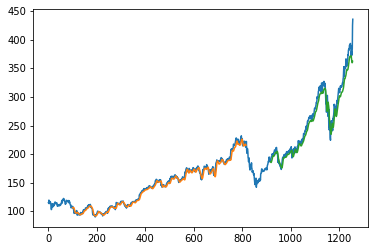

In [29]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1) # Return a new array with the same shape and type as a given array.
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:
len(test_data)

440

In [36]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [37]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [38]:
temp_input

[0.45710894299528093,
 0.5432095191222027,
 0.4396803798384529,
 0.47051330303118044,
 0.4525925711473321,
 0.4471208129469326,
 0.40213080107698107,
 0.38803161460293567,
 0.4532005442807099,
 0.44926319446454943,
 0.4866680177180742,
 0.45569033901739964,
 0.47615876784111644,
 0.4746533105584667,
 0.43591673663182884,
 0.4475550794707739,
 0.43736429171129965,
 0.49833531165860867,
 0.4895341767754263,
 0.5087577082307981,
 0.514316319735966,
 0.5295445991719985,
 0.5694971193653919,
 0.5619119307489651,
 0.5684548797081729,
 0.5571929011898903,
 0.5401986045569035,
 0.5154164615963638,
 0.537795663124982,
 0.5346978952549144,
 0.5576850699169105,
 0.5582640919486987,
 0.544975536319157,
 0.5714657942734722,
 0.5890391129382474,
 0.5753452418864538,
 0.5871862424365248,
 0.5999247271358675,
 0.6088127153238181,
 0.6178165079181264,
 0.6363162618337628,
 0.6504443994093976,
 0.6400220028372081,
 0.6291363886395878,
 0.6346081468399873,
 0.6293100952491242,
 0.6502996439014505,
 0.645

In [39]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.85752237]
101
1 day input [0.54320952 0.43968038 0.4705133  0.45259257 0.44712081 0.4021308
 0.38803161 0.45320054 0.44926319 0.48666802 0.45569034 0.47615877
 0.47465331 0.43591674 0.44755508 0.43736429 0.49833531 0.48953418
 0.50875771 0.51431632 0.5295446  0.56949712 0.56191193 0.56845488
 0.5571929  0.5401986  0.51541646 0.53779566 0.5346979  0.55768507
 0.55826409 0.54497554 0.57146579 0.58903911 0.57534524 0.58718624
 0.59992473 0.60881272 0.61781651 0.63631626 0.6504444  0.640022
 0.62913639 0.63460815 0.6293101  0.65029964 0.64503054 0.66266176
 0.6557714  0.66167743 0.65542399 0.65941924 0.65982456 0.65892707
 0.67024695 0.67456067 0.67971396 0.67160765 0.69818477 0.70385918
 0.73434469 0.75996642 0.71092325 0.71931907 0.73144958 0.75776613
 0.75634753 0.75675284 0.75093367 0.77742393 0.79960047 0.78086911
 0.79470774 0.76225355 0.7858487  0.79459193 0.79259431 0.79259431
 0.82079268 0.81743435 0.84256391 0.84731189 0.84925161 0.84412727
 0.86242437 0.87015431 0.85622883 0.

9 day output [[0.75490654]]
10 day input [0.48666802 0.45569034 0.47615877 0.47465331 0.43591674 0.44755508
 0.43736429 0.49833531 0.48953418 0.50875771 0.51431632 0.5295446
 0.56949712 0.56191193 0.56845488 0.5571929  0.5401986  0.51541646
 0.53779566 0.5346979  0.55768507 0.55826409 0.54497554 0.57146579
 0.58903911 0.57534524 0.58718624 0.59992473 0.60881272 0.61781651
 0.63631626 0.6504444  0.640022   0.62913639 0.63460815 0.6293101
 0.65029964 0.64503054 0.66266176 0.6557714  0.66167743 0.65542399
 0.65941924 0.65982456 0.65892707 0.67024695 0.67456067 0.67971396
 0.67160765 0.69818477 0.70385918 0.73434469 0.75996642 0.71092325
 0.71931907 0.73144958 0.75776613 0.75634753 0.75675284 0.75093367
 0.77742393 0.79960047 0.78086911 0.79470774 0.76225355 0.7858487
 0.79459193 0.79259431 0.79259431 0.82079268 0.81743435 0.84256391
 0.84731189 0.84925161 0.84412727 0.86242437 0.87015431 0.85622883
 0.85397064 0.87747894 0.86175849 0.86491416 0.81364176 0.81097826
 0.83639732 0.81836079 0

18 day output [[0.68451285]]
19 day input [0.50875771 0.51431632 0.5295446  0.56949712 0.56191193 0.56845488
 0.5571929  0.5401986  0.51541646 0.53779566 0.5346979  0.55768507
 0.55826409 0.54497554 0.57146579 0.58903911 0.57534524 0.58718624
 0.59992473 0.60881272 0.61781651 0.63631626 0.6504444  0.640022
 0.62913639 0.63460815 0.6293101  0.65029964 0.64503054 0.66266176
 0.6557714  0.66167743 0.65542399 0.65941924 0.65982456 0.65892707
 0.67024695 0.67456067 0.67971396 0.67160765 0.69818477 0.70385918
 0.73434469 0.75996642 0.71092325 0.71931907 0.73144958 0.75776613
 0.75634753 0.75675284 0.75093367 0.77742393 0.79960047 0.78086911
 0.79470774 0.76225355 0.7858487  0.79459193 0.79259431 0.79259431
 0.82079268 0.81743435 0.84256391 0.84731189 0.84925161 0.84412727
 0.86242437 0.87015431 0.85622883 0.85397064 0.87747894 0.86175849
 0.86491416 0.81364176 0.81097826 0.83639732 0.81836079 0.83906083
 0.85237833 0.96899337 1.         0.85752237 0.87952662 0.88030255
 0.86712623 0.84735173

27 day output [[0.63720053]]
28 day input [0.53779566 0.5346979  0.55768507 0.55826409 0.54497554 0.57146579
 0.58903911 0.57534524 0.58718624 0.59992473 0.60881272 0.61781651
 0.63631626 0.6504444  0.640022   0.62913639 0.63460815 0.6293101
 0.65029964 0.64503054 0.66266176 0.6557714  0.66167743 0.65542399
 0.65941924 0.65982456 0.65892707 0.67024695 0.67456067 0.67971396
 0.67160765 0.69818477 0.70385918 0.73434469 0.75996642 0.71092325
 0.71931907 0.73144958 0.75776613 0.75634753 0.75675284 0.75093367
 0.77742393 0.79960047 0.78086911 0.79470774 0.76225355 0.7858487
 0.79459193 0.79259431 0.79259431 0.82079268 0.81743435 0.84256391
 0.84731189 0.84925161 0.84412727 0.86242437 0.87015431 0.85622883
 0.85397064 0.87747894 0.86175849 0.86491416 0.81364176 0.81097826
 0.83639732 0.81836079 0.83906083 0.85237833 0.96899337 1.
 0.85752237 0.87952662 0.88030255 0.86712623 0.84735173 0.82587534
 0.80521959 0.78638673 0.76962948 0.75490654 0.74208629 0.73100621
 0.72148037 0.71329927 0.70623

In [40]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [41]:
len(df1)

1257

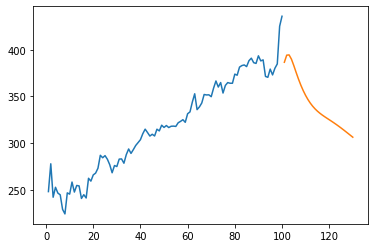

In [42]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

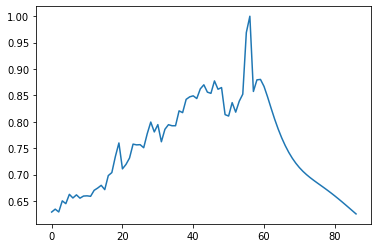

In [43]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [44]:
df3=scaler.inverse_transform(df3).tolist()

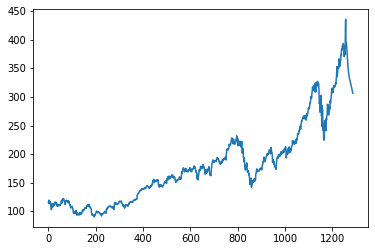

In [45]:
plt.plot(df3)

In [46]:
a = scaler.inverse_transform(lst_output)

In [47]:
a

array([[386.53680128],
       [394.13728814],
       [394.40530325],
       [389.85406987],
       [383.02376101],
       [375.60560184],
       [368.47089881],
       [361.96583982],
       [356.17771815],
       [351.09226631],
       [346.66402588],
       [342.8368533 ],
       [339.54653445],
       [336.72070239],
       [334.27988726],
       [332.14196339],
       [330.22671976],
       [328.4600806 ],
       [326.77758477],
       [325.12632099],
       [323.46571025],
       [321.76758809],
       [320.01498998],
       [318.20110127],
       [316.32684843],
       [314.39976668],
       [312.43130296],
       [310.43543657],
       [308.42721735],
       [306.42124222]])